In [1]:
import warnings, pickle, os
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)})

import shap
import optuna

%load_ext autoreload
%autoreload 1

In [2]:
from utils.evaluation import plot_roc_curves, plot_pr_curves, plot_calibration_curves, plot_alert_rate, plot_confusion_matrix, evaluate_all_outcomes, evaluate_multiple, plot_calibrated_regression_coefficients, confusion_matrix_multiplot, plot_shap_features_joint
from hyperparameter_tuning import tune_lgbm, tune_logisticregression
from utils.data_profiling import ensure_categorical_overlap, drop_exclusive_cols
from dataset import SCIData, SCICols
%aimport utils.evaluation, hyperparameter_tuning, dataset, utils.data_profiling

In [9]:
class Notebook:
    IMAGE_DIR = "images/clinical_models_calibrated_shmi_sdec_2"
    SAVE_IMAGES = True

    RUN_HYPERPARAMETERS = True
    HYPERPARAMETER_TIMEOUT = 60 * 60
    HYPERPARAMETER_TRIALS = 1000
    HYPERPARAMETER_NJOBS = -1

    SHAP_PLOTS_MAXDISPLAY = 20
    EVAL_N_RESAMPLES = 999

    MODELS = {}
    EXPLAINERS = {}
    Y_PREDS = {}


try:
    os.makedirs(Notebook.IMAGE_DIR)
except FileExistsError:
    pass


In [4]:
from sklearn.model_selection import train_test_split

sci = (
    SCIData(SCIData.quickload("data/sci_processed.h5").sort_values("AdmissionDateTime"))
    .mandate(SCICols.news_data_raw)
    .omit_ae()
)

scii = (
    sci.derive_critical_event(within=1, return_subcols=True)
    .augment_shmi(onehot=True)
    .omit_redundant()
    .raw_news()
    .categorize()
    .onehot_encode_categories()
)

sci_train, sci_test, _, y_test_mortality, _, y_test_criticalcare = train_test_split(
    scii.drop(["DiedWithinThreshold", "CriticalCare"], axis=1),
    scii.DiedWithinThreshold,
    scii.CriticalCare,
    test_size=0.33,
    random_state=42,
    shuffle=False,
)
sci_train, sci_test = SCIData(sci_train), SCIData(sci_test)

test_set_n_days = (
    sci.loc[sci_test.index].AdmissionDateTime.max() - sci.loc[sci_test.index].AdmissionDateTime.min()
).days



In [5]:
(X_train_lr, y_train), (X_test_lr, y_test) = (
    sci_train.impute_blood().xy(outcome="CriticalEvent", dropna=False, fillna=True),
    sci_test.impute_blood().xy(outcome="CriticalEvent", dropna=False, fillna=True)
)

(X_train_lgbm, y_train), (X_test_lgbm, y_test) = (
    sci_train.xy(outcome="CriticalEvent", dropna=False, fillna=False),
    sci_test.xy(outcome="CriticalEvent", dropna=False, fillna=False)
)

(X_train_news, _), (X_test_news, _) = (
    sci_train#.impute_news().impute_blood()
    .xy(
        outcome="CriticalEvent",
        x=SCICols.news_data_raw,
        dtype=float,
        dropna=False,
        fillna=False,
    ),
    sci_test#.impute_news().impute_blood()
    .xy(
        outcome="CriticalEvent",
        x=SCICols.news_data_raw,
        dtype=float,
        dropna=False,
        fillna=False,
    ),
)


In [6]:
from sklearn.metrics import precision_recall_curve


def get_threshold(y_train, y_pred_proba, target=0.85):
    """ Given prediction probabilities, sets the prediction threshold to approach the given target recall
    """

    # Get candidate thresholds from the model, and find the one that gives the best fbeta score
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred_proba)
    closest = thresholds[np.abs(recall - target).argmin()]

    return closest


In [10]:
def benchmark(y_pred, y_pred_proba, modelkey, filekey, tuning=False):
    evaluate_all_outcomes(
        y_test,
        y_test_mortality,
        y_test_criticalcare,
        y_pred,
        y_pred_proba,
        modelkey,
        n_resamples=Notebook.EVAL_N_RESAMPLES,
        save=f"{Notebook.IMAGE_DIR}/eval_{filekey}.png"
        if Notebook.SAVE_IMAGES
        else None,
    )
    plot_confusion_matrix(
        y_test,
        y_pred,
        plot_title=modelkey,
        save=f"{Notebook.IMAGE_DIR}/matrix_{filekey}.png"
        if Notebook.SAVE_IMAGES
        else None,
    )

    if not tuning:
        Notebook.Y_PREDS[modelkey] = (y_pred, y_pred_proba)
    else:
        modelkey = f"{modelkey} (tuned)"
        y_pred = np.where(y_pred_proba > get_threshold(y_test, y_pred_proba), 1, 0)
        evaluate_all_outcomes(
            y_test,
            y_test_mortality,
            y_test_criticalcare,
            y_pred,
            y_pred_proba,
            modelkey,
            n_resamples=Notebook.EVAL_N_RESAMPLES,
            save=f"{Notebook.IMAGE_DIR}/eval_thresholded_{filekey}.png"
            if Notebook.SAVE_IMAGES
            else None,
        )
        plot_confusion_matrix(
            y_test,
            y_pred,
            plot_title=modelkey,
            save=f"{Notebook.IMAGE_DIR}/matrix_thresholded_{filekey}.png"
            if Notebook.SAVE_IMAGES
            else None,
        )
        Notebook.Y_PREDS[modelkey] = (y_pred, y_pred_proba)


# Models

## Baseline (NEWS)

,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
Baseline (NEWS),,,,,,,
Critical event,0.969003,0.283916,0.217811,0.246509,0.228449,0.801963,0.802 (0.786-0.818)
Mortality only,0.983090,0.109091,0.661017,0.187275,0.328559,0.930540,0.931 (0.898-0.960)
Critical care,0.968154,0.187413,0.161836,0.173688,0.166377,0.784928,0.785 (0.767-0.802)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


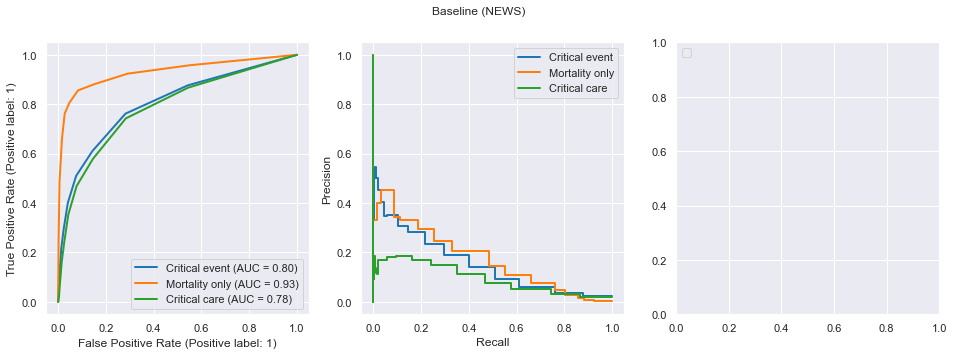

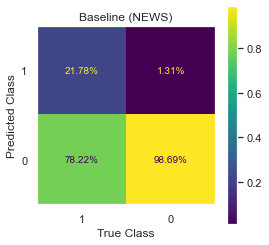

In [11]:
benchmark(
    (sci.loc[sci_test.index].NEWS_score >= 7).to_numpy(),
    sci.loc[sci_test.index].NEWS_score.to_numpy(),
    "Baseline (NEWS)",
    "news",
    tuning=False,
)


## Logistic Regression (NEWS only)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

lr_news_params = {
    'max_iter': 1000,
    'random_state': 42,
    'penalty': 'l2',
    'solver': 'lbfgs',
    'C': 7.85,
    'class_weight': 'balanced',
}


if Notebook.RUN_HYPERPARAMETERS:
    lr_news_params.update(
        tune_logisticregression(
            X_train_news,
            y_train,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
            n_trials=Notebook.HYPERPARAMETER_TRIALS,
        )
    )

modelkey = "NEWS Logistic Regression"
model = (
    CalibratedClassifierCV(
        LogisticRegression().set_params(**lr_news_params), cv=5, method='isotonic', n_jobs=Notebook.HYPERPARAMETER_NJOBS
    ).fit(X_train_news, y_train)
)
Notebook.MODELS[modelkey] = model


Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "c:\Users\stybl\miniconda3\envs\py39\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "c:\Users\stybl\miniconda3\envs\py39\lib\site-packages\joblib\externals\loky\process_executor.py", line 563, in run
    result_item, is_broken, bpe = self.wait_result_broken_or_wakeup()
  File "c:\Users\stybl\miniconda3\envs\py39\lib\site-packages\joblib\externals\loky\process_executor.py", line 617, in wait_result_broken_or_wakeup
    ready = wait(readers + worker_sentinels)
  File "c:\Users\stybl\miniconda3\envs\py39\lib\multiprocessing\connection.py", line 884, in wait
    ready_handles = _exhaustive_wait(waithandle_to_obj.keys(), timeout)
  File "c:\Users\stybl\miniconda3\envs\py39\lib\multiprocessing\connection.py", line 816, in _exhaustive_wait
    res = _winapi.WaitForMultipleObjects(L, False, timeout)
ValueError: need at most 63 handles, got a sequence of length 1000


In [ ]:
benchmark(
    model.predict(X_test_news),
    model.predict_proba(X_test_news)[:, 1],
    modelkey,
    "news_regression",
    tuning=True,
)



In [ ]:
plot_calibrated_regression_coefficients(model, X_train_news.columns, topn=10, figsize=(8,4), save = f'{Notebook.IMAGE_DIR}/logistic_regression_coef.png' if Notebook.SAVE_IMAGES else None)

In [ ]:
explainers = [
    shap.LinearExplainer(
        _.base_estimator, X_train_news, feature_perturbation='correlation_dependent'
    )(X_test_news)
    for _ in model.calibrated_classifiers_
]
shap_values = shap.Explanation(
    base_values = np.array([_.base_values for _ in explainers]).mean(axis=0),
    values = np.array([_.values for _ in explainers]).mean(axis=0),
    data = explainers[0].data,
    feature_names = X_train_news.columns
)
Notebook.EXPLAINERS[modelkey] = shap_values

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("NEWS Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_news_regression.png", bbox_inches="tight", dpi=200
    )


In [ ]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("NEWS Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_news_regression.png", bbox_inches="tight", dpi=200
    )


In [ ]:
plot_shap_features_joint(
    shap_values, 
    modelkey, 
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    figsize=(16,5),
    wspace=-0.2,
    save = f'{Notebook.IMAGE_DIR}/shap_features_news_regression.png' if Notebook.SAVE_IMAGES else None
)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV

lr_params = {
    'max_iter': 1000,
    'random_state': 42,
    'penalty': 'l2',
    'solver': 'lbfgs',
    'C': 9.16316,
    'class_weight': 'balanced',
}


if Notebook.RUN_HYPERPARAMETERS:
    lr_params.update(
        tune_logisticregression(
            X_train_lr,
            y_train,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
            n_trials=Notebook.HYPERPARAMETER_TRIALS,
        )
    )

modelkey = "Logistic Regression"
model = (
    CalibratedClassifierCV(
        LogisticRegression().set_params(**lr_params), cv=5, method='isotonic', n_jobs=Notebook.HYPERPARAMETER_NJOBS
    ).fit(X_train_lr, y_train)
)
Notebook.MODELS[modelkey] = model


In [ ]:
plot_calibrated_regression_coefficients(model, X_train_lr.columns, save = f'{Notebook.IMAGE_DIR}/logistic_regression_coef.png' if Notebook.SAVE_IMAGES else None)

In [ ]:
benchmark(
    model.predict(X_test_lr),
    model.predict_proba(X_test_lr)[:, 1],
    modelkey,
    "logistic_regression",
    tuning=True,
)



In [ ]:
explainers = [
    shap.LinearExplainer(
        _.base_estimator, X_train_lr, feature_perturbation='correlation_dependent'
    )(X_test_lr)
    for _ in model.calibrated_classifiers_
]
shap_values = shap.Explanation(
    base_values = np.array([_.base_values for _ in explainers]).mean(axis=0),
    values = np.array([_.values for _ in explainers]).mean(axis=0),
    data = explainers[0].data,
    feature_names = X_train_lr.columns
)
Notebook.EXPLAINERS[modelkey] = shap_values

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_logistic_regression.png", bbox_inches="tight", dpi=200
    )


In [ ]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_logsitic_regression.png", bbox_inches="tight", dpi=200
    )


In [ ]:
plot_shap_features_joint(
    shap_values, 
    modelkey, 
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    figsize=(16,8),
    wspace=-0.3,
    save = f'{Notebook.IMAGE_DIR}/shap_features_logistic_regression.png' if Notebook.SAVE_IMAGES else None
)

## LightGBM

In [ ]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.calibration import CalibratedClassifierCV

lgbm_params = {
    'LGBM__objective': 'binary',
    'LGBM__verbose_eval': -1,
    'LGBM__random_state': 42,
    'LGBM__metrics': ['l2', 'auc'],
    'LGBM__boosting_type': 'gbdt',
    'LGBM__is_unbalance': True,
    'LGBM__n_jobs': 1,
    'LGBM__feature_pre_filter': False,
    'LGBM__lambda_l1': 0.996,
    'LGBM__lambda_l2': 0.013,
    'LGBM__num_leaves': 6,
    'LGBM__feature_fraction': 0.726,
    'LGBM__bagging_fraction': 0.701,
    'LGBM__bagging_freq': 4,
    'LGBM__min_child_samples': 16,
    'IMB__sampling_strategy': 0.11
}

if Notebook.RUN_HYPERPARAMETERS:
    lgbm_params.update(
        tune_lgbm(
            X_train_lr,
            y_train,
            None,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
            n_trials=Notebook.HYPERPARAMETER_TRIALS
        )
    )

modelkey = "LightGBM"
model = (
    CalibratedClassifierCV(
        ImbPipeline(
            steps=[
                ("IMB", RandomUnderSampler()), 
                ("LGBM", LGBMClassifier())
            ]
        ).set_params(**lgbm_params),
        cv=5,
        method='isotonic',
        n_jobs=Notebook.HYPERPARAMETER_NJOBS
    ).fit(
        X_train_lgbm,
        y_train
    )
)

Notebook.MODELS[modelkey] = model


In [ ]:
benchmark(
    model.predict(X_test_lgbm),
    model.predict_proba(X_test_lgbm)[:, 1],
    modelkey,
    "lightgbm",
    tuning=True,
)



In [ ]:
explainers = [
    shap.TreeExplainer(_.base_estimator['LGBM'])(X_test_lgbm)
    for _ in model.calibrated_classifiers_
]
shap_values = shap.Explanation(
    base_values = np.array([_.base_values for _ in explainers]).mean(axis=0),
    values = np.array([_.values for _ in explainers]).mean(axis=0),
    data = explainers[0].data,
    feature_names = X_train_lgbm.columns
)
Notebook.EXPLAINERS[modelkey] = shap_values

In [ ]:
plot_shap_features_joint(
    shap_values[:, :, 1], 
    modelkey, 
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    figsize=(16,8),
    wspace=-0.225,
    save = f'{Notebook.IMAGE_DIR}/shap_features_lightgbm.png' if Notebook.SAVE_IMAGES else None
)

In [ ]:
fig = shap.plots.beeswarm(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("LightGBM")
if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_lightgbm.png", bbox_inches="tight", dpi=200)


In [ ]:
fig = shap.plots.bar(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("LightGBM")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_lightgbm.png", bbox_inches="tight"), dpi=200


# Comparisons

In [ ]:
Notebook.Y_PREDS = dict(reversed(Notebook.Y_PREDS.items()))

In [ ]:
from utils.evaluation import evaluate_multiple

evaluate_multiple(
    y_test,
    Notebook.Y_PREDS,
    news_modelkey="Baseline (NEWS)",
    save=f"{Notebook.IMAGE_DIR}/combined_curves.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
    alert_rate_n_days = test_set_n_days,
)



In [ ]:
confusion_matrix_multiplot(y_test, dict(reversed(Notebook.Y_PREDS.items())), save=f'{Notebook.IMAGE_DIR}/combined_matrices.png' if Notebook.SAVE_IMAGES else None)

In [ ]:
plot_roc_curves(y_test, Notebook.Y_PREDS, baseline_key='Baseline (NEWS)', save=f'{Notebook.IMAGE_DIR}/combined_roc.png' if Notebook.SAVE_IMAGES else None)

In [ ]:
plot_pr_curves(y_test, Notebook.Y_PREDS, baseline_key='Baseline (NEWS)', save=f'{Notebook.IMAGE_DIR}/combined_pr.png' if Notebook.SAVE_IMAGES else None)

In [ ]:
plot_calibration_curves(y_test, Notebook.Y_PREDS, save=f'{Notebook.IMAGE_DIR}/combined_calibration.png' if Notebook.SAVE_IMAGES else None)

In [ ]:
plot_alert_rate(y_test, Notebook.Y_PREDS, test_set_n_days, baseline_key='Baseline (NEWS)', save=f'{Notebook.IMAGE_DIR}/combined_alert_rate.png' if Notebook.SAVE_IMAGES else None)

## SHAP

In [ ]:
def patient_force_plots(patient):
    patient_data = X_test_lr.loc[patient].apply(
        lambda x: f"{x:.2f}" if type(x) == np.float64 else x
    )
    patient_idx = X_test_lr.index.get_loc(patient)

    explanations = {
        modelkey: shap_values[patient_idx]
        for modelkey, shap_values in Notebook.EXPLAINERS.items()
        if not modelkey in ["Baseline (NEWS)"]
    }
    for _ in explanations.keys():
        if len(explanations[_].shape) > 1:
            explanations[_] = explanations[_][:, 1]

    sns.set_style("white")
    plt.rc("axes", titlesize=16)
    for modelkey, explanation in explanations.items():
        patient_to_use = patient_data if modelkey != "NEWS Logistic Regression" else patient_data[SCICols.news_data_raw]

        explanation = shap.Explanation(explanation)
        explanation.data = patient_to_use.values

        fig = shap.plots.force(
            explanation,
            feature_names=patient_to_use.index,
            matplotlib=True,
            contribution_threshold=0.08,
            show=False,
            text_rotation=15,
        )

        plt.title(modelkey)
        display(fig)

        if Notebook.SAVE_IMAGES:
            plt.savefig(
                f"{Notebook.IMAGE_DIR}/comaprison_force_plot_{modelkey.replace(' ','')}.png",
                bbox_inches="tight", dpi=200
            )

        plt.clf()

    sns.set_style("darkgrid")

In [ ]:
preds_df = pd.DataFrame({key:val[0] for key, val in Notebook.Y_PREDS.items()}).astype(bool).set_index(y_test.index)
candidate_mask = (
    preds_df['LightGBM (tuned)'] & 
    ~preds_df['Baseline (NEWS)'] & 
    y_test.astype(bool) &
    (X_test_lr.AssistedBreathing == 0)
)
candidates = preds_df[candidate_mask].index

patient_force_plots(55599)

In [ ]:
# def patient_decision_plots(patient):
#     patient_data = X_test_lr.loc[patient].apply(
#         lambda x: f"{x:.2f}" if type(x) == np.float64 else x
#     )
#     patient_idx = X_test_lr.index.get_loc(patient)

#     explanations = {
#         modelkey: shap_values[patient_idx]
#         for modelkey, shap_values in Notebook.EXPLAINERS.items()
#         if not modelkey in ["Baseline (NEWS)"]
#     }
#     for _ in explanations.keys():
#         if len(explanations[_].shape) > 1:
#             explanations[_] = explanations[_][:, 1]

#     sns.set_style("white")
#     plt.rc("axes", titlesize=16)
#     for modelkey, explanation in explanations.items():
#         patient_to_use = patient_data if modelkey != "NEWS Logistic Regression" else patient_data[SCICols.news_data_raw]
        
#         fig = plt.figure()
#         shap.decision_plot(explanation.base_values, explanation.values, explanation.data, explanation.feature_names, show=False)
#         plt.title(modelkey)
        
#         if Notebook.SAVE_IMAGES:
#             plt.savefig(
#                 f"{Notebook.IMAGE_DIR}/comaprison_force_plot_{modelkey.replace(' ','')}.png",
#                 bbox_inches="tight", dpi=200
#             )

#         #plt.clf()

# patient_decision_plots(55599)